# Validation: Heldout Data Example

This notebook:

* loads a library defined model. 
* loads the data according to the data preprocessor class.
* holds-out the final few days of the data, and see's if they can be predicted. 

The way I propose doing this is holding out the confirmed observations for the final three days of the day for every country, and then plotting it for validation. This effectively changes the output model. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel.pymc3_models.utils import geom_convolution
from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor

%matplotlib inline

INFO:epimodel.regions:Name index has 6 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands']
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:
Countermeasures                               min   .. mean  .. max
 0 Gatherings limited to                      0.000 .. 0.177 .. 0.982
 1 Business suspended                         0.000 .. 0.273 .. 1.000
 2 Schools and universities closed            0.000 .. 0.361 .. 1.000
 3 General curfew                             0.000 .. 0.167 .. 1.000
 4 Healthcare specialisation                  0.000 .. 0.020 .. 0.429
 5 Phone line                                 0.000 .. 0.032 .. 1.000
 6 Asymptomatic contact isolation             0.000 .. 0.053 .. 1.000


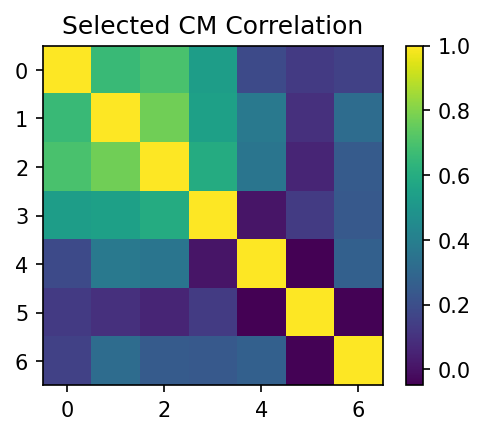

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Data Preprocessing Complete using:

{
    "start_date": "2020-2-10",
    "end_date": "2020-04-05",
    "min_final_num_active_cases": 100,
    "min_num_active_mask": 10,
    "min_num_confirmed_mask": 10
}


In [3]:
regions = ["PT", "IS", "HU", "HR", "BE", "NL", "DK", "DE", "AT", "CZ", "GE", "FR", "ES", "GB", "PL", "GR", "CH", "FI", "NO", "SE", "SI", "SK"]
features = ['Gatherings limited to', 'Business suspended', 'Schools and universities closed', 'General curfew',
       'Healthcare specialisation', 'Phone line', 'Asymptomatic contact isolation']

dp = DataPreprocessor()
data = dp.preprocess_data("../../data", regions, features)

In [36]:
with cm_effect.models.CMModelFlexibleV2(data) as model:
    model.build_all()

[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55]
56
10
46


/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in Observed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
INFO:epimodel.pymc3_models.cm_effect.models:Checking model test point
INFO:epimodel.pymc3_models.cm_effect.models:
CMReduction_log__             9.69
BaseGrowthRate_log__         -1.61
RegionGrowthRate_log__        6.27
RegionScaleMult_log__       -20.22
DailyGrowth_log__          1400.25
InitialSize_log__           -70.87
Observed_missing              0.00
Observed                 -15098.43
Name: Log-probability of test_point, dtype: float64



In [38]:
model.run(2000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...


CMReduction_log__             9.69
BaseGrowthRate_log__         -1.61
RegionGrowthRate_log__        6.27
RegionScaleMult_log__       -20.22
DailyGrowth_log__          1400.25
InitialSize_log__           -70.87
Observed_missing              0.00
Observed                 -15098.43
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Observed_missing, InitialSize, DailyGrowth, RegionScaleMult, RegionGrowthRate, BaseGrowthRate, CMReduction]
INFO:pymc3:NUTS: [Observed_missing, InitialSize, DailyGrowth, RegionScaleMult, RegionGrowthRate, BaseGrowthRate, CMReduction]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [07:08<00:00, 11.66draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8796991130444679, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


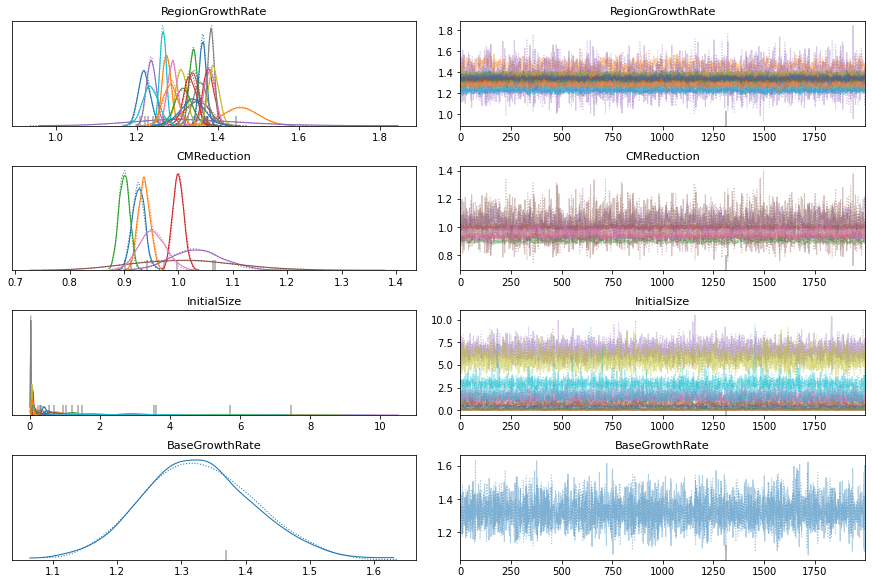

In [40]:
_ = model.plot_traces()

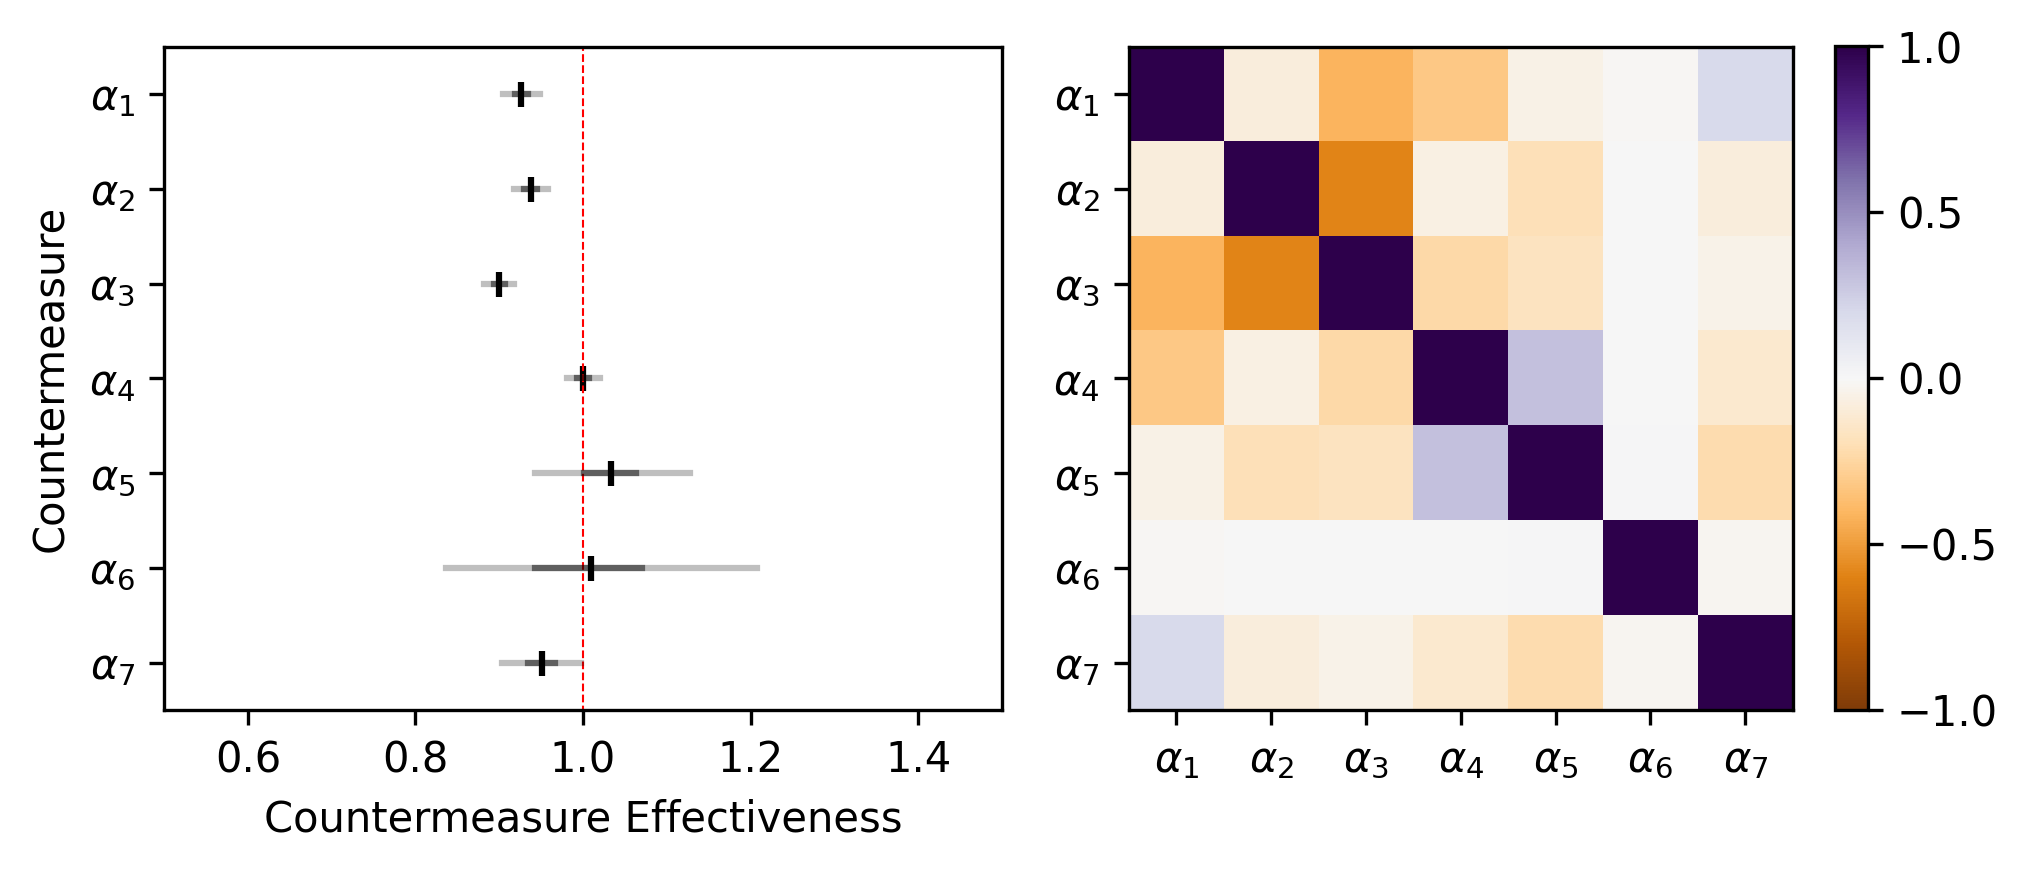

In [100]:
model.plot_effect()

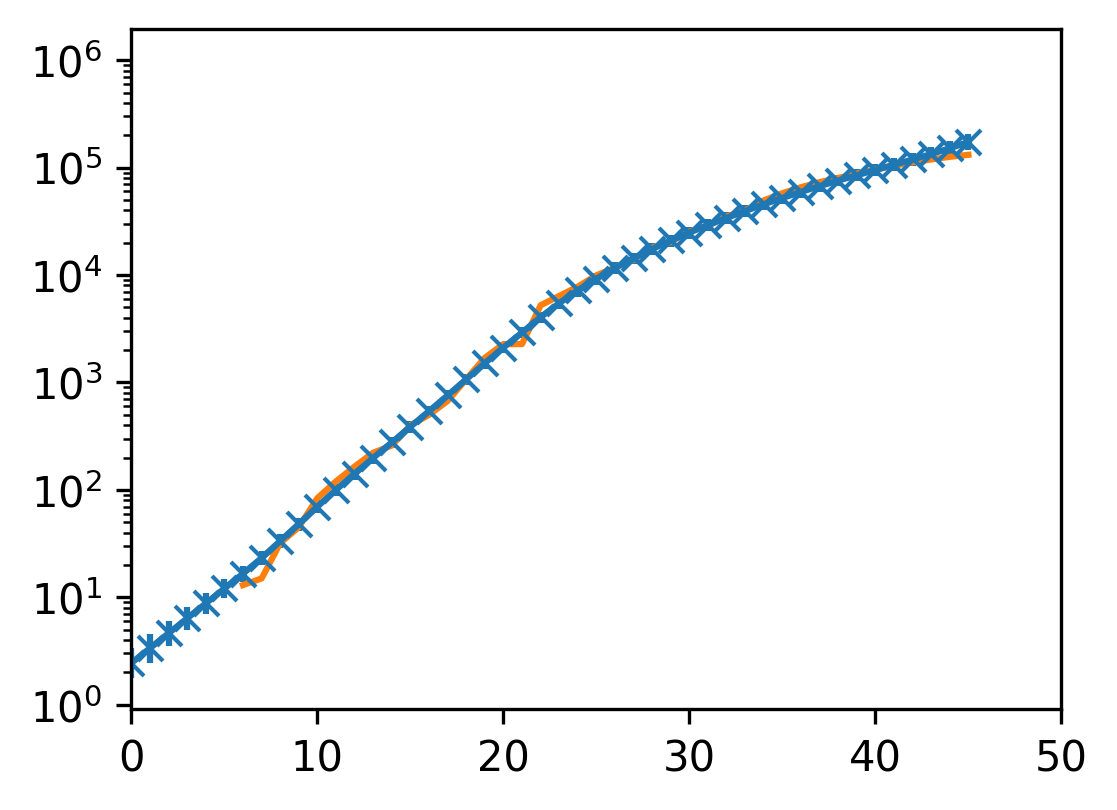

In [135]:
country_indx = 1
means = np.mean(model.trace.ObservedSize[:, 6, :], axis=0)
li = np.percentile(model.trace.ObservedSize[:, 6, :], 2.5, axis=0)
ui = np.percentile(model.trace.ObservedSize[:, 6, :], 97.5, axis=0)
err = np.array([means-li, ui-means])

labels = model.d.Confirmed[6, 10:]

max_val = 10 ** np.ceil(np.log10(max(np.max(ui), np.max(labels))))
min_val = 10 ** np.floor(np.log10(min(np.min(li), np.min(labels))))

plt.figure(figsize=(4, 3), dpi=300)
plt.errorbar(np.arange(46), means, yerr=err, fmt="-x")
plt.plot(np.arange(46), labels)
ax = plt.gca()
ax.set_yscale("log")
plt.plot([0, 10 ** 6], [0, 10 ** 6], "-r")
plt.xlim([0, 50]);

# Inspect Spain

Let's hold spain out. 

['AT', 'BE', 'CH', 'CZ', 'DE', 'DK', 'ES', 'FI', 'FR', 'GB', 'GE', 'GR', 'HR', 'HU', 'IS', 'NL', 'NO', 'PL', 'PT', 'SE', 'SI', 'SK']


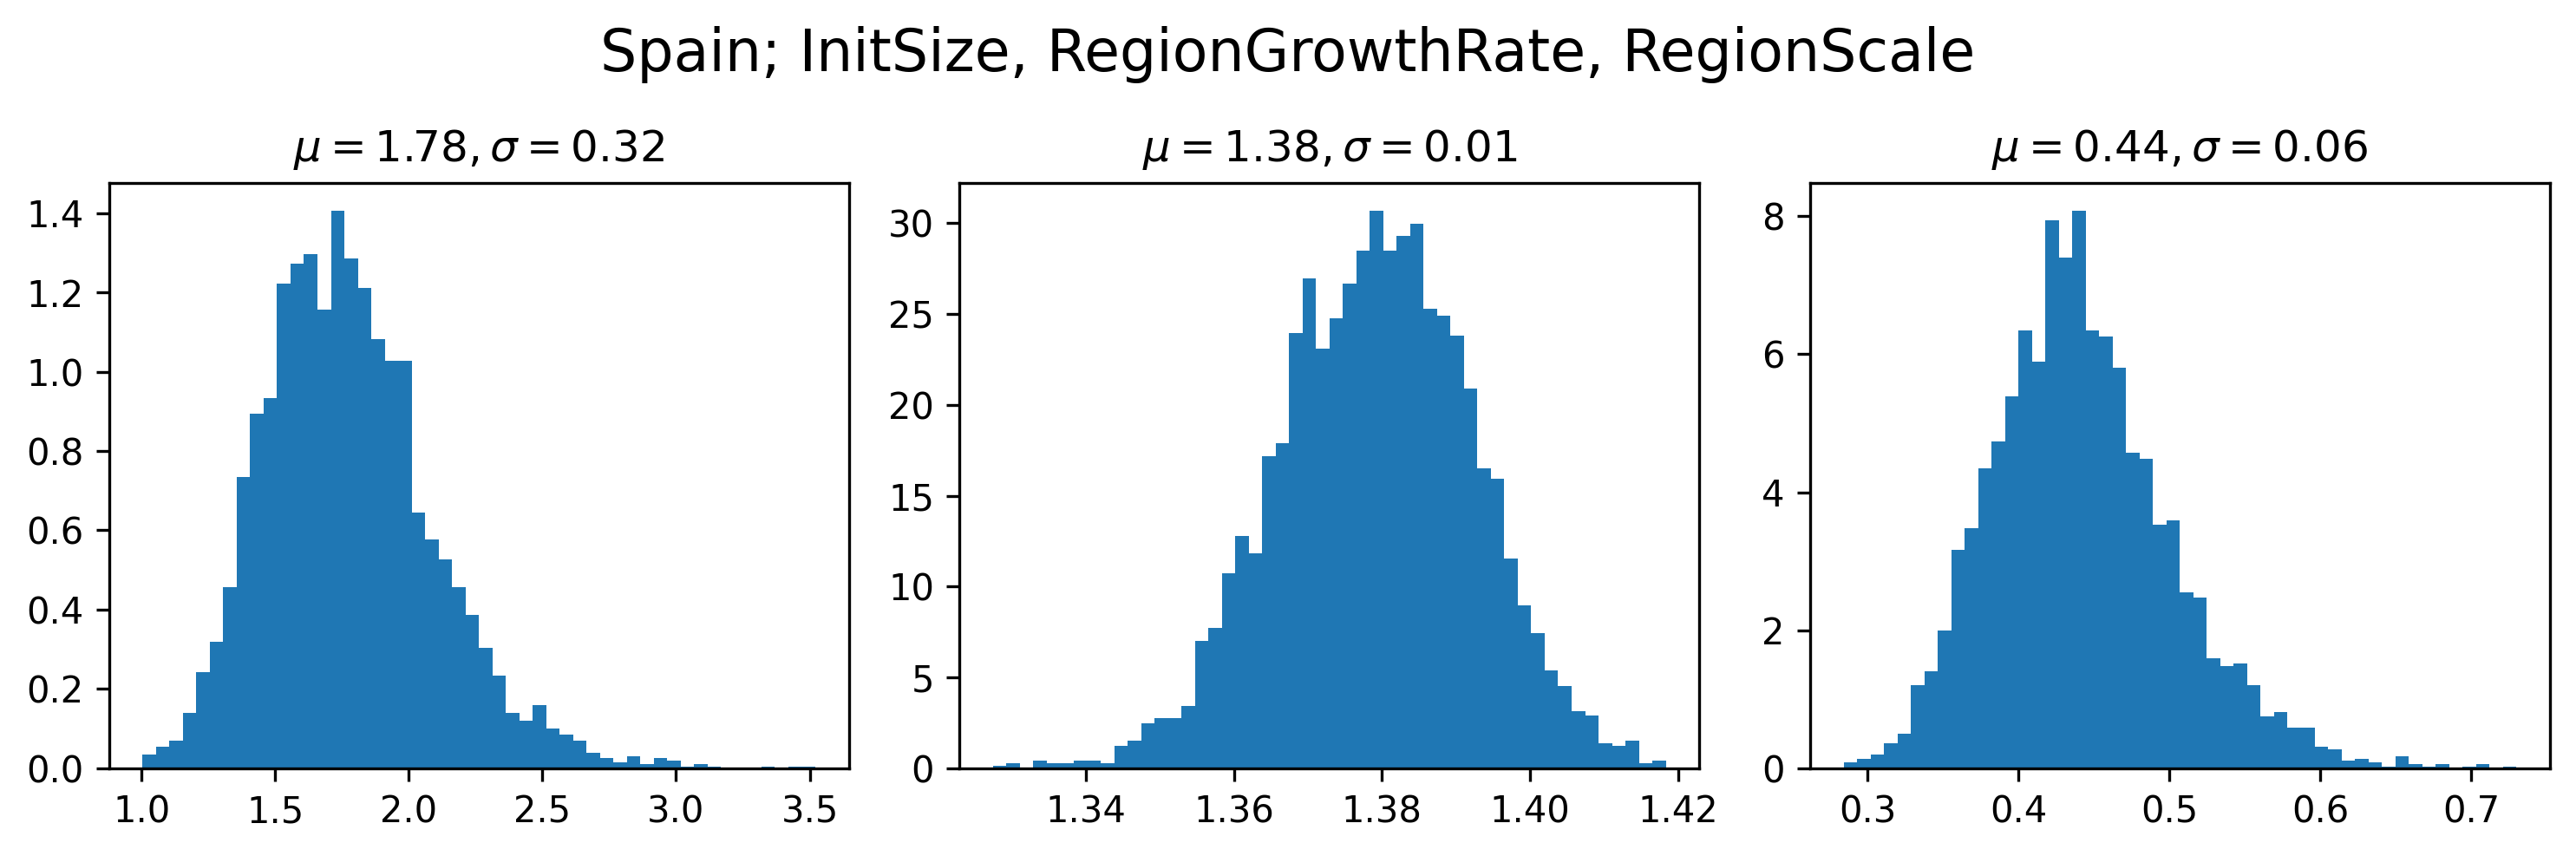

In [43]:
fig = plt.figure(figsize=(10, 3), dpi=300)
print(model.d.Rs)
plt.subplot(1, 3, 1)
plt.hist(model.trace["InitialSize"][:, 6], bins=50,  density=True)
plt.title(f"$\\mu = {np.mean(model.trace['InitialSize'][:, 6]):.2f}, \\sigma = {np.std(model.trace['InitialSize'][:, 6]):.2f}$") 
plt.subplot(1, 3, 2)
plt.hist(model.trace["RegionGrowthRate"][:, 6], bins=50,  density=True)
plt.title(f"$\\mu = {np.mean(model.trace['RegionGrowthRate'][:, 6]):.2f}, \\sigma = {np.std(model.trace['RegionGrowthRate'][:, 6]):.2f}$") 
plt.subplot(1, 3, 3)
plt.hist(model.trace["RegionScaleMult"][:, 6], bins=50,  density=True);
plt.title(f"$\\mu = {np.mean(model.trace['RegionScaleMult'][:, 6]):.2f}, \\sigma = {np.std(model.trace['RegionScaleMult'][:, 6]):.2f}$") 
fig.suptitle('Spain; InitSize, RegionGrowthRate, RegionScale', fontsize=16, y=1.08)
plt.tight_layout()

Worth noting that these distributions don't look particularly Gaussian for when we want to provide initial estimates. I'll use a normal distribution though. 

In [51]:
with cm_effect.models.CMModelFlexibleV2(data, heldout_regions=["ES"]) as model2:
    model2.build_reduction_lognorm()
    model2.build_heldout_region_priors(pm.Normal, {"mu": 1.78, "sigma": 0.32}, pm.Normal, {"mu": 1.38, "sigma": 0.01}, pm.Normal, {"mu": 0.44, "sigma": 0.06})
    model2.build_rates()
    model2.build_output_model()

In [52]:
model2.run(2000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...


CMReduction_log__               9.69
HeldoutInitialSize              0.22
HeldoutGrowthRate               3.69
HeldoutRegionScale              1.89
BaseGrowthRate_log__           -1.61
RegionGrowthRate_log__          5.99
RegionScaleMult_log__         -19.30
DailyGrowth_log__            1336.60
HeldoutDailyGrowth_log__      101.41
InitialSize_log__             -67.65
Observed_missing                0.00
HeldoutObserved_log__          37.64
Observed                   -13000.66
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [HeldoutObserved, Observed_missing, InitialSize, HeldoutDailyGrowth, DailyGrowth, RegionScaleMult, RegionGrowthRate, BaseGrowthRate, HeldoutRegionScale, HeldoutGrowthRate, HeldoutInitialSize, CMReduction]
INFO:pymc3:NUTS: [HeldoutObserved, Observed_missing, InitialSize, HeldoutDailyGrowth, DailyGrowth, RegionScaleMult, RegionGrowthRate, BaseGrowthRate, HeldoutRegionScale, HeldoutGrowthRate, HeldoutInitialSize, CMReduction]
Sampling 2 chains, 2 divergences: 100%|██████████| 5000/5000 [08:56<00:00,  9.32draws/s]
The acceptance probability does not match the target. It is 0.8851571240462013, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the targe

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1512b4c50>],
      dtype=object)

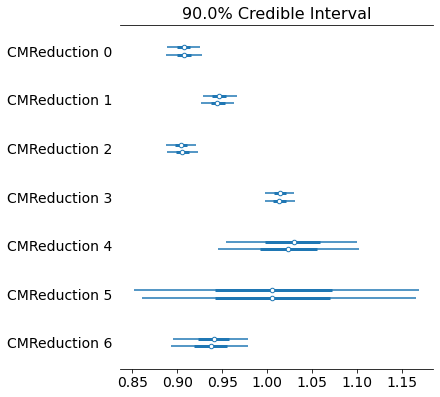

In [54]:
model2.plot_effect()

INFO:epimodel.pymc3_models.cm_effect.models:Saving Day Validation Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/heldout_validation/out


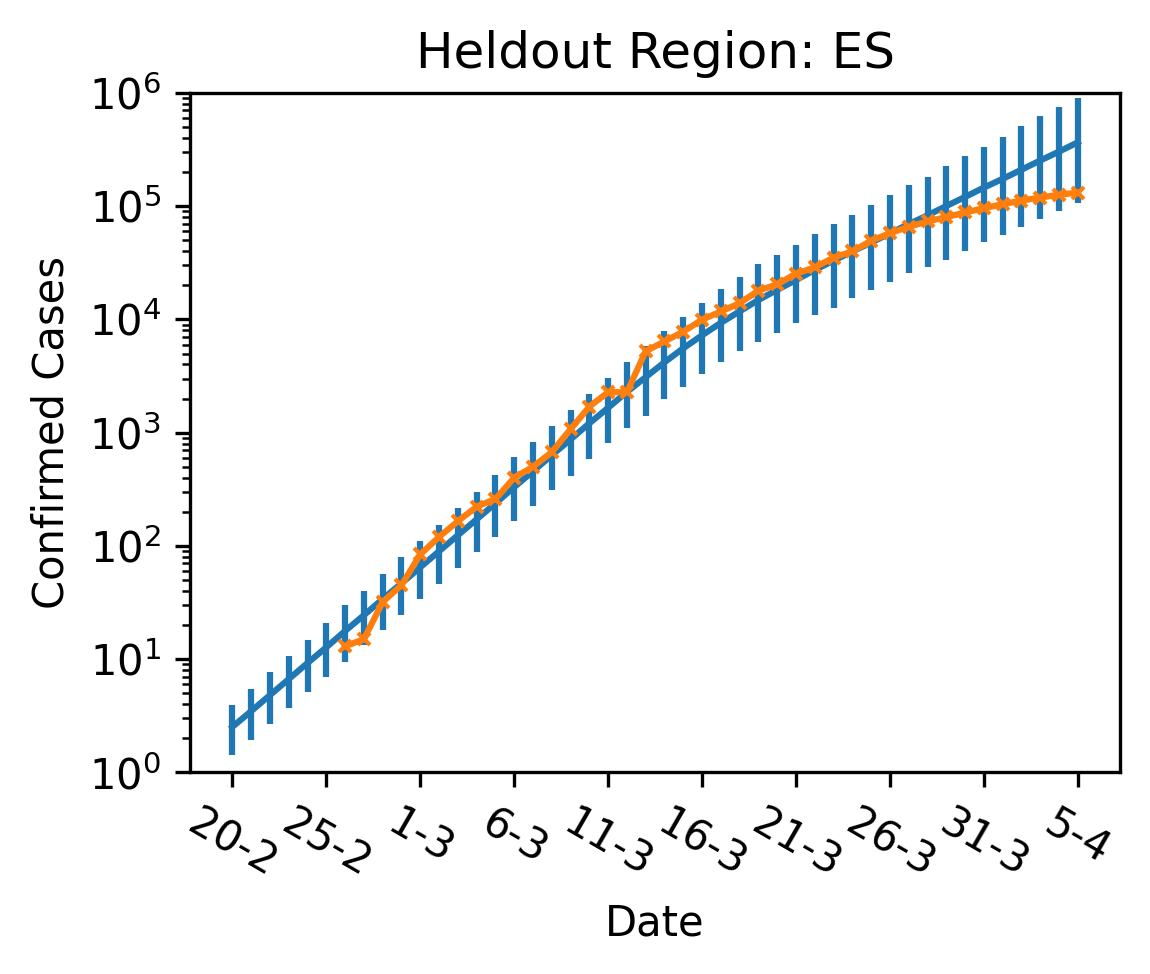

In [76]:
model2.heldout_regions_validation_plot()

# Let's holdout the final 3 days. 

In [60]:
with cm_effect.models.CMModelFlexibleV2(data, heldout_days=[53, 54, 55]) as model3:
    model3.build_all()

/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in Observed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
INFO:epimodel.pymc3_models.cm_effect.models:Checking model test point
INFO:epimodel.pymc3_models.cm_effect.models:
CMReduction_log__             9.69
BaseGrowthRate_log__         -1.61
RegionGrowthRate_log__        6.27
RegionScaleMult_log__       -20.22
DailyGrowth_log__          1400.25
InitialSize_log__           -70.87
Observed_missing              0.00
Observed                 -13857.06
Name: Log-probability of test_point, dtype: float64



In [62]:
model3.run(2000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...


CMReduction_log__             9.69
BaseGrowthRate_log__         -1.61
RegionGrowthRate_log__        6.27
RegionScaleMult_log__       -20.22
DailyGrowth_log__          1400.25
InitialSize_log__           -70.87
Observed_missing              0.00
Observed                 -13857.06
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Observed_missing, InitialSize, DailyGrowth, RegionScaleMult, RegionGrowthRate, BaseGrowthRate, CMReduction]
INFO:pymc3:NUTS: [Observed_missing, InitialSize, DailyGrowth, RegionScaleMult, RegionGrowthRate, BaseGrowthRate, CMReduction]
Sampling 2 chains, 17 divergences: 100%|██████████| 5000/5000 [08:08<00:00, 10.24draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8867326752917746, but should be close to 0.8. Try to increase the number of tuning steps.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some p

INFO:epimodel.pymc3_models.cm_effect.models:Saving Day Validation Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/heldout_validation/out
INFO:epimodel.pymc3_models.cm_effect.models:Saving Day Validation Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/heldout_validation/out
INFO:epimodel.pymc3_models.cm_effect.models:Saving Day Validation Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/heldout_validation/out


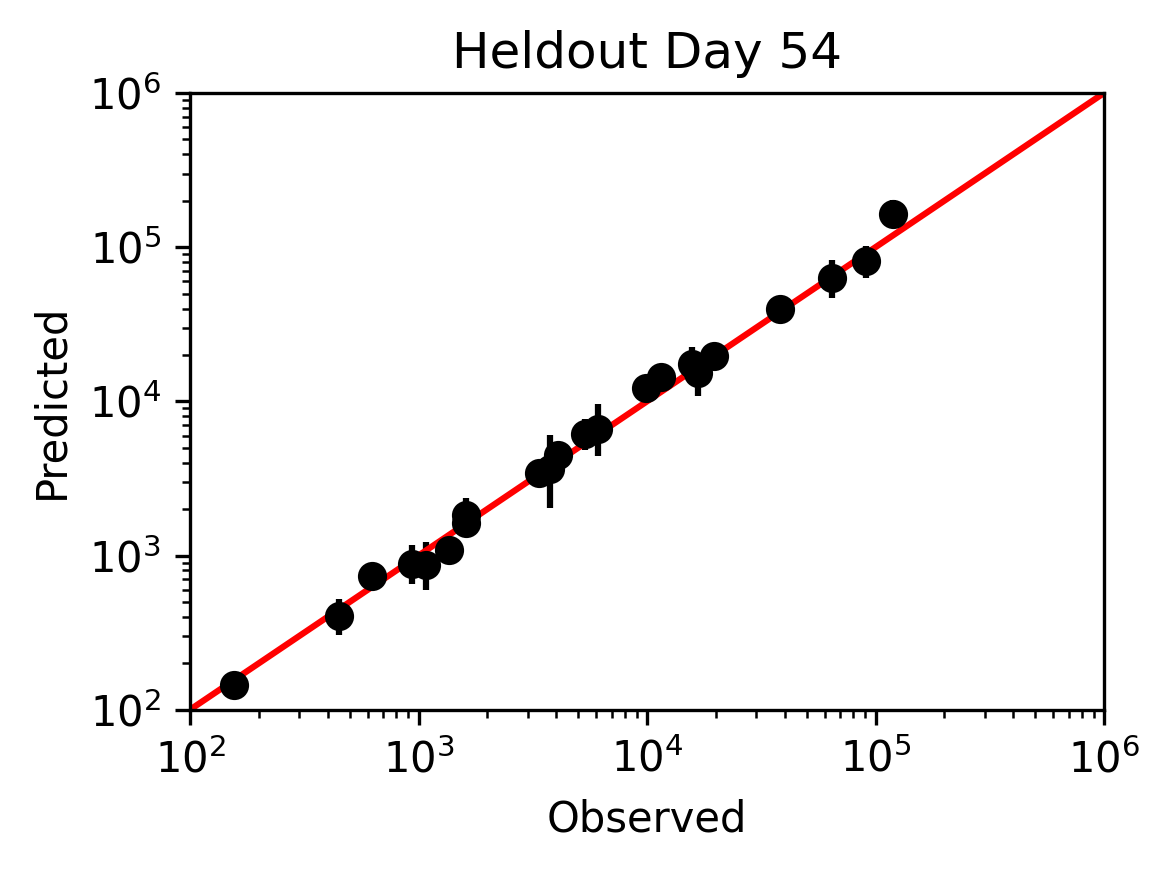

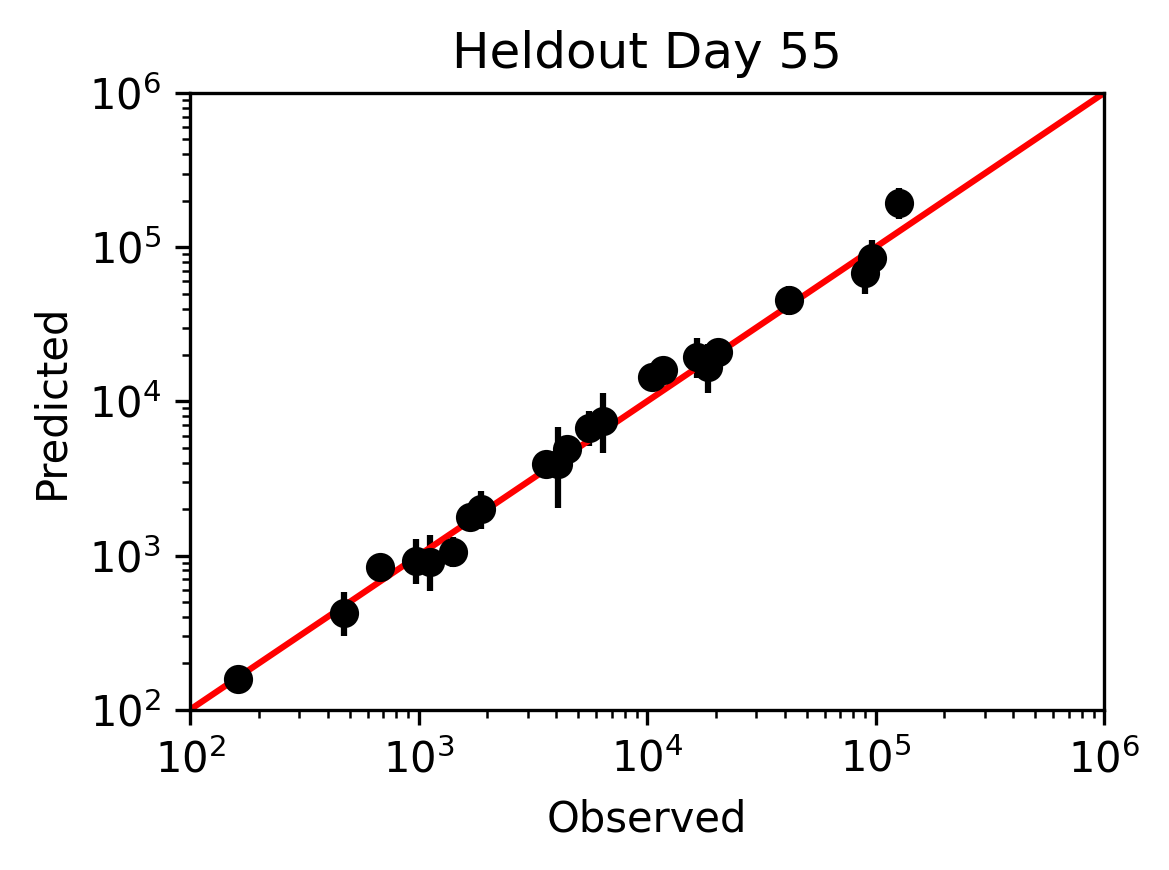

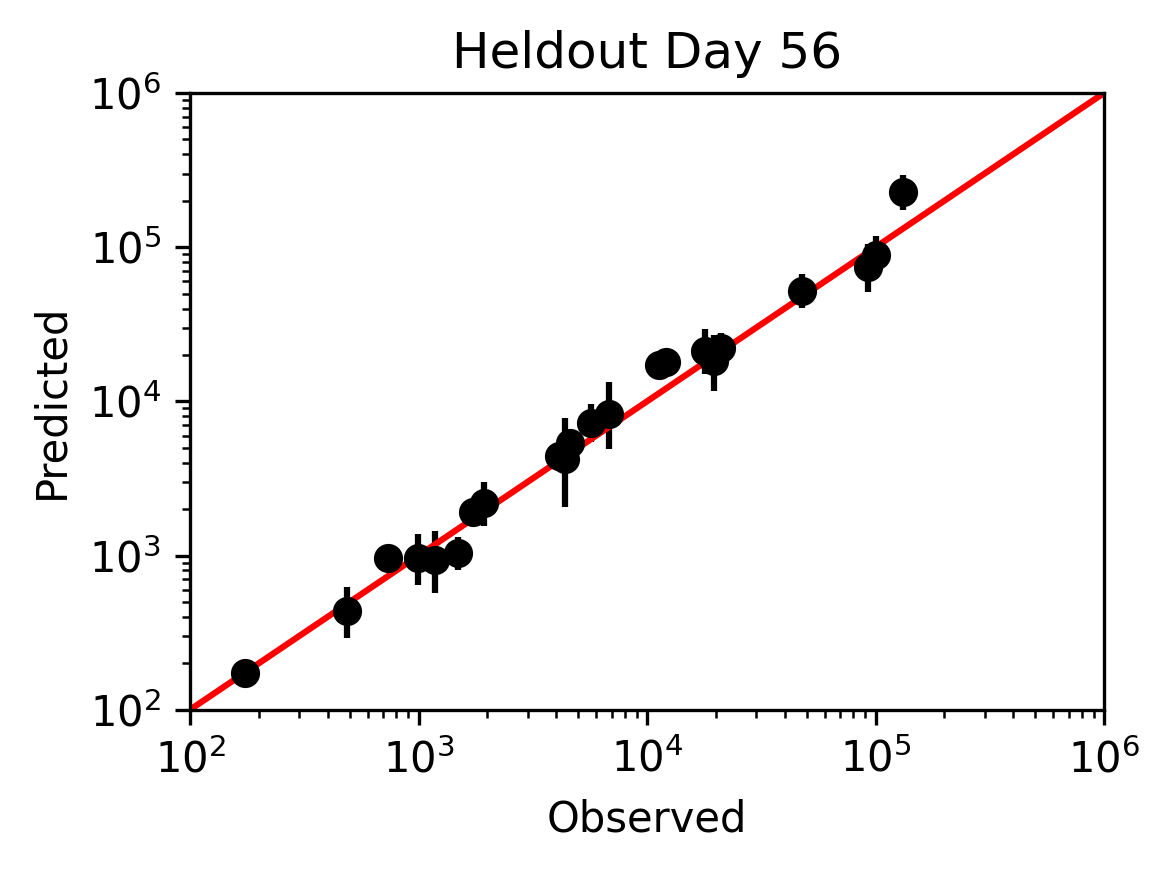

In [75]:
model3.heldout_days_validation_plot()